# Gerador de dados sísmicos paralelizado

## Imports e configurações 

In [1]:
import matplotlib
import matplotlib.pyplot as plt

from time import time
from joblib import Parallel, delayed
from scipy.signal import convolve2d
from tqdm import tqdm
from utils import * 

import multiprocessing as mp
import numpy as np
import cv2
import random
import os
import shutil
import glob

In [2]:
path_save_retas = './../Code_Pix2Pix/datasets/seismic_e2'
path_save_curves = './../Code_Pix2Pix/datasets/seismic_e3'
delete_existing_samples = False

## Utils

In [3]:
class ImageUtil:
    @staticmethod
    def show_img(img, scala=1, color='gray', show_axis=False):
        fig, ax = plt.subplots()
        if not show_axis: ax.axis("off")
        ax.imshow(img, cmap=color)
        dpi = float(fig.get_dpi())
        img_width = int(img.shape[0] / dpi)
        img_height = int(img.shape[1] / dpi)
        fig.set_size_inches(scala * img_width, scala * img_height)

    
    @staticmethod
    def open_image(path, color_code=cv2.COLOR_BGR2RGB):
        return cv2.cvtColor(cv2.imread(path), color_code) 

    
    @staticmethod
    def save_img(img, path, color=None):
        # 'seismic'
        vmax = np.max(abs(img))
        plt.imsave(path, img, cmap=color, vmin=-vmax, vmax=vmax)
    
    @staticmethod
    def norm_image(img, negative=True):
        vmin, vmax = img.min(), img.max() 
        img = (img - vmin) / (vmax - vmin)
        if negative:
            img = img * 2 - 1
        return img

## PSFs e Ricker

###### Carregando as PSFs

Dados carregados de ./janelas/jequitinhonha.pickle
 - scatter_widths
 - frequencies
 - scatters
Visualizando '' - 6 amostras


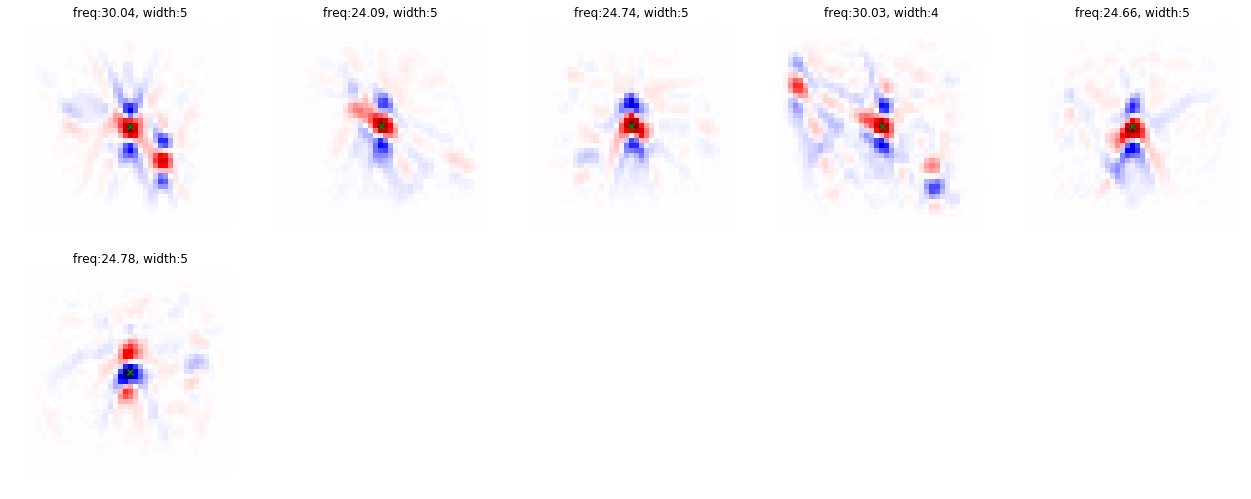

In [4]:
# Arquivo com PSFs
psf_file = './janelas/jequitinhonha.pickle'

data_dic = load_pickle(psf_file)
scatters = data_dic['scatters']
frequencies = data_dic['frequencies']
scatter_widths = data_dic['scatter_widths']

# Visualiza PSFs importados
max_samples = 30
color='seismic'
resize=3.5

# Cria título informativo para cada janela
labels = ['freq:%.2f, width:%d' % (f,w) for f,w in zip(frequencies, scatter_widths)]

if max_samples < scatters.shape[0]:
    num_samples = max_samples
else:
    num_samples = None
    
view_samples(scatters, labels, num_samples=num_samples, resize=resize, color=color)

###### Função que retorna uma das PSFs carregadas

In [5]:
def get_random_psf(return_infos=False):
    # Seleciona um PSF para convolver com o dado de estruturas
    # A ultima PSF não pode ser inserida pois está com a polaridade invertida e a Ricker não.
    psf_index = random.randint(0, len(scatters) - 2)
    
    psf = scatters[psf_index]
    psf_freq = frequencies[psf_index]
    psf_width = scatter_widths[psf_index]

    title = 'freq:%.2f, width:%d' % (psf_freq, psf_width)
    
    if return_infos:
        return psf, psf_freq, psf_width
    else:
        return psf

###### Gerando a Wavelet de Ricker

In [6]:
psf, psf_freq, psf_width = get_random_psf(return_infos=True)
taper_size = 4
window_size = psf.shape[0]
dt = 0.004

# Constrói wavelet
wavelet = ricker_wavelet(psf_freq, window_size, dt)
# Constrói wavelet 2D
wavelet = wavelet.reshape((1,-1)).T
wavelet_2D = np.empty((window_size, taper_size*2+1), dtype=np.float32)
wavelet_2D[:,:] = wavelet
# Suaviza bordas aplicando função de taper
wavelet_2D = apply_taper(wavelet_2D, taper_size)
print("Wavelet_2D", wavelet_2D.shape)

def get_ricker():
    return wavelet_2D 

Wavelet_2D (41, 9)


###### Mostrando um exemplo

Tamanho da imagem (em polegadas): 5.69 x 5.69
Coordenadas:  x - [0.0, 41.0], y - [0.0, 0.2]
Dimensão: (41, 41)



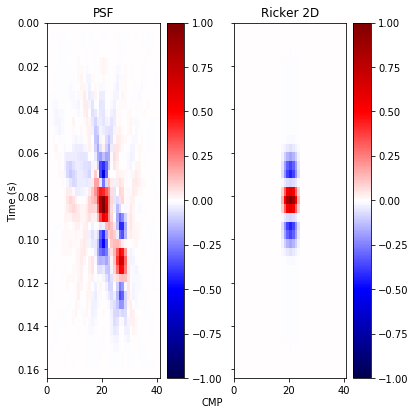

In [7]:
# Constrói janela para visualização equivalente ao PSF
color='seismic'
resize=10.0

title1='PSF'
title2='Ricker 2D'
    
center = int(window_size/2)  
wavelet_window = np.zeros(psf.shape)
wavelet_window[:, center-taper_size:center+(taper_size+1)] += wavelet_2D

multiple_event_viewer(psf, wavelet_window, resize=resize, color1=color, color2=color, dt=dt, title1=title1, title2=title2)

## Gerador do dataset

###### Função para gerar exemplos com retas

In [8]:
def make_sample_retas(i, psf, wavelet_2D, debug=False):
    img_ref = np.zeros((256, 256))
    n_retas = random.randint(10, 15)

    for i in range(n_retas):
        x = random.randint(1, 127)
        y = random.randint(1, 255)
        size = random.randint(127, 255 - x)
        reta = np.ones((1, size))
        img_ref[y, x:x+size] = reta

    noise = 0.1
    img_back = (np.random.random(img_ref.shape) - 0.5) * noise
    noisy_img_ref = img_back + img_ref

    synthetic_psf = convolve2d(noisy_img_ref, psf, mode='same')
    synthetic_ricker2D = convolve2d(noisy_img_ref, wavelet_2D, mode='same')
    
    if debug:
        multiple_event_viewer(noisy_img_ref, synthetic_psf, synthetic_ricker2D,
                          vmin1=0, vmax1=1.0,
                          resize=3, color1='gray', color2='seismic', color3='seismic',
                          title1='Refletores', title2='synthetic_psf', title3='synthetic_ricker2D')

    return synthetic_psf, synthetic_ricker2D

Tamanho da imagem (em polegadas): 10.67 x 10.67
Coordenadas:  x - [0.0, 256.0], y - [0.0, 256.0]
Dimensão: (256, 256)



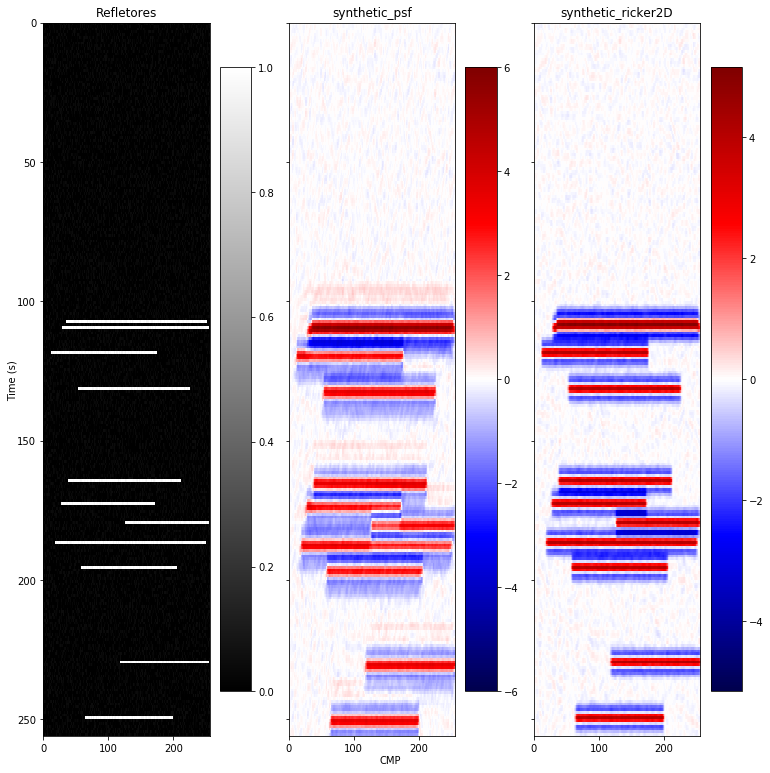

In [9]:
x, y = make_sample_retas(0, get_random_psf(), get_ricker(), True)

###### Função para gerar exemplos com curva - 
## Em contrução

In [14]:
def plot_to_numpy(fig):
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data


def generate_curves(file_name):
    num_steps = 1000
    num_sections = 2
    theta_end = (2*np.pi)*0.4

    sections = np.empty(num_sections+1, dtype=np.int)
    sections[0] = 0
    sections[-1] = num_steps
    if num_sections > 1:
        sections[1:-1] = np.sort(np.random.choice(np.arange(int(num_steps*0.05),int(num_steps*0.95)),
                                                  (num_sections-1),replace=False))

    count = 0
    phase = np.random.random()*(2*np.pi)
    theta = np.empty(num_steps, dtype=np.float32)
    for begin,end in zip(sections[:-1],sections[1:]):
        theta[begin:end] = 2**count
        count+=1

    theta = np.arange(0,theta_end,theta_end/num_steps) + theta + phase
    chaos = np.cos(theta) + np.sin(theta)
    beta = 0.98
    
    fig = plt.figure()
    ax = fig.gca()
    fig.tight_layout(pad=0)

    for offset in range(50, 950, 50):
        sigma = np.random.rand() + 1.0
        random_walk = np.empty(num_steps, dtype=np.float32)
        step = (np.random.random() - 0.5) * 8
        for i in range(num_steps):
            random_walk[i] = step
            step = (1-beta)*np.random.normal(loc=chaos[i], scale=sigma) + beta*step
        random_walk -= random_walk.min()

        scale = np.random.rand() * 30 + 30
        reflective_curve = np.round((random_walk*scale) + offset)

        ax.plot(range(num_steps), reflective_curve)

    plt.ylim((0, num_steps))
    ax.set_axis_off()
    # data = plot_to_numpy(fig)
    # im = fig2img ( figure )
    # im.show()
    plt.savefig(file_name)
    plt.cla()
    plt.close()
    
    # return data
    
    
def make_sample_curves(i, psf, wavelet_2D, debug=True):
    # img_ref = generate_curves(str(i) + ".jpg")[:-50, 55:-35]
    # img_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)
    generate_curves(str(i) + ".jpg")
    img_ref = ImageUtil.open_image(str(i) + ".jpg", cv2.COLOR_BGR2GRAY)[:-50, 55:-35]
    img_ref = (255 - img_ref) / 255
    
    noise = 0.1
    img_back = (np.random.random(img_ref.shape) - 0.5) * noise
    noisy_img_ref = img_back + img_ref
    
    # Convolução 
    synthetic_psf = convolve2d(noisy_img_ref, psf, mode='same')
    synthetic_ricker2D = convolve2d(noisy_img_ref, wavelet_2D, mode='same')
    
    # Normalização 
    synthetic_psf /= np.max(np.abs(synthetic_psf))
    synthetic_ricker2D /= np.max(np.abs(synthetic_ricker2D))
    
    if debug:
        print("Original Size: ", synthetic_psf.shape)
    
    # Redimensionamento
    synthetic_psf = cv2.resize(synthetic_psf, (256, 256))
    synthetic_ricker2D = cv2.resize(synthetic_ricker2D, (256, 256))
    
    if debug:
        print("Refletores: ", img_ref.min(), img_ref.max())
        print("PSF:", psf.min(), psf.max())
        print("Ricker:", wavelet_2D.min(), wavelet_2D.max())
        
        multiple_event_viewer(noisy_img_ref, synthetic_psf, synthetic_ricker2D,
                              vmin1=0, vmax1=1.0,
                              resize=3, color1='gray', color2='seismic', color3='seismic',
                              title1='Refletores', title2='synthetic_psf', title3='synthetic_ricker2D')
    
    return synthetic_psf, synthetic_ricker2D

Original Size:  (238, 342)
Refletores:  0.0 0.6705882352941176
PSF: -0.6157858 1.0
Ricker: -0.43408415 1.0
Tamanho da imagem (em polegadas): 14.25 x 9.92
Coordenadas:  x - [0.0, 342.0], y - [0.0, 238.0]
Dimensão: (238, 342)



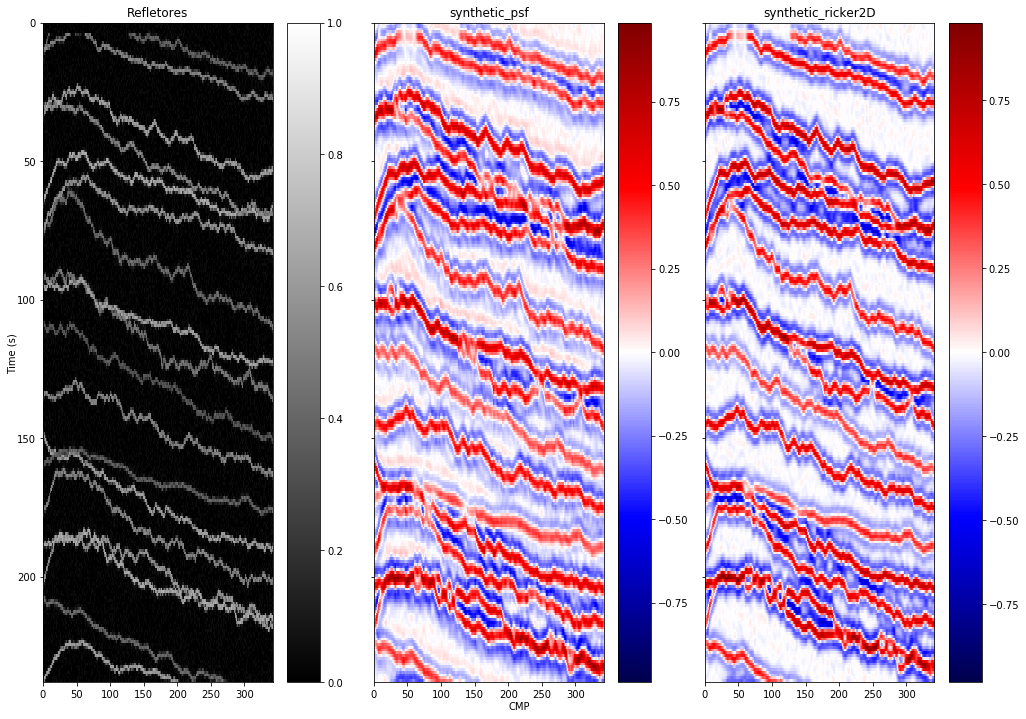

Gastos:  1.6690657138824463
X: -0.6768808460030429 0.9872846829278186
Y: -0.6649059619690003 0.9806640043202952


In [15]:
t = time()
x, y = make_sample_curves(0, get_random_psf(), get_ricker(), True)
print("Gastos: ", time() - t)

print("X:", x.min(), x.max())
print("Y:", y.min(), y.max())

In [12]:
def process_sample(make_sample_func, path, i):
    x, y = make_sample_func(i, get_random_psf(), get_ricker())
    img = np.append(x, y, axis=1)
    ImageUtil.save_img(img, path + "/" + str(i) + ".jpg", color='seismic')
    
def create_dataset(n_samples, tipos_refletores, path):
    start_time = time()
    
    if tipos_refletores == 'retas': msf = make_sample_retas 
    else: msf = make_sample_curves 
        
    if not os.path.exists(path): 
        os.mkdir(path)
    elif delete_existing_samples:
        shutil.rmtree(path, ignore_errors=True)
        os.mkdir(path)    
    
    folders = [ ("train", n_samples), 
                ("val", int(n_samples * 0.2)), 
                ("test", int(n_samples * 0.2)) ]
    
    nc = mp.cpu_count()
    print("Cpu count: ", nc)
    
    for j in range(len(folders)):
        
        print("Generating: ", folders[j][0])
        path_temp = path + "/" + folders[j][0]
        start = 0
        
        if not os.path.exists(path_temp):
            os.mkdir(path_temp)
        else:
            files = glob.glob(path_temp + "/*.jpg")
            files.sort(key=lambda x: int(x.split('/')[-1][:-4]))
            if len(files) > 0: start = int(files[-1].split('/')[-1][:-4]) + 1
        Parallel(n_jobs=nc)(delayed(process_sample) (msf, path_temp, i) for i in tqdm(range(start, folders[j][1])))
    
    for folder in folders:
        path_temp = path + "/" + folder[0]
        print("Total de imagens de {0}: {1}".format(folder[1], len(glob.glob(path_temp + "/*.jpg"))))
        
    !rm -rf *.jpg
    print("Time: ", time() - start_time)

In [13]:
# create_dataset(10000, "curves", path_save_curves)
create_dataset(1000, 'retas', path_save_retas)

  0%|          | 0/999 [00:00<?, ?it/s]

Cpu count:  8
Generating:  train


  0%|          | 0/200 [00:00<?, ?it/s]

Generating:  val


  0%|          | 0/200 [00:00<?, ?it/s]

Generating:  test


100%|██████████| 200/200 [00:19<00:00, 10.52it/s]


Total de imagens de 1000: 1000
Total de imagens de 200: 200
Total de imagens de 200: 200
Time:  141.26207184791565
